# Automated Object Detection using YOLOv3.
This assignment is a modified version of source https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb

You will learn about object detection using the very powerful YOLO model. Many of the ideas in this notebook are described in the two YOLO papers: Redmon et al., 2016 and Redmon and Farhadi, 2016.

You will learn how to use a pre-trained model and fine tune it on new data.

# A. Start by connecting colab to your local Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create a Folder named 'YOLOv3' in your Google Drive. 
## This is the folder where all code and data will be collected.

In [2]:
import os
os.chdir('/content/drive/MyDrive/Notebooks')

### 1. Now lets install all requirements for the code base! 
This can take sometime!

In [3]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
#!pip install -r requirements-gpu.txt
!pip install -e .

fatal: destination path 'yolov3-tf2' already exists and is not an empty directory.
/content/drive/MyDrive/Notebooks/yolov3-tf2
Obtaining file:///content/drive/MyDrive/Notebooks/yolov3-tf2
  Attempting uninstall: yolov3-tf2
    Found existing installation: yolov3-tf2 0.1
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2


##### 2.  Check Tensorflow2 version

In [4]:
#Ensure you are located inside directory yolov3-tf2/. If not use the command 
%cd yolov3-tf2


/content/drive/My Drive/Notebooks/yolov3-tf2/yolov3-tf2


In [5]:
!ls

checkpoints	 data		  logs			setup.py
colab_gpu.ipynb  detect.py	  output.jpg		tools
conda-cpu.yml	 detect_video.py  README.md		train.py
conda-gpu.yml	 docs		  requirements-gpu.txt	yolov3_tf2
convert.py	 LICENSE	  requirements.txt	yolov3_tf2.egg-info


In [13]:
!pip install tensorflow
import tensorflow as tf
tf.__version__

'2.6.0'

In [6]:
import tensorflow as tf
tf.keras.layers.LayerNormalization

keras.layers.normalization.layer_normalization.LayerNormalization

# Download the test_images.zip, unzip them and manually move the images to './data/' folder. You will be required to run all experiments on these test images. You may have to rerun the notebook till this point to refresh the data folders.

##### 3.  Now we retrieve a Pretrained model weights.
To learn more about DarkNet and its pretrained models refer to: https://towardsdatascience.com/custom-object-detection-using-darknet-9779170faca2

In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2021-09-20 03:08:06--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M  37.4MB/s    in 6.5s    

2021-09-20 03:08:13 (36.3 MB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2021-09-20 03:08:16.133244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:08:16.143355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:08:16.144230: I tensorflow/stream_executor/c

## 4 - Problem Statement

If you are building an objector for a self-driving car use case, a critical component of this project, is a specific object detector, i.e cars only or pedestrians only etc. To collect data, you've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while you drive around. 

<center>
<video width="400" height="200" src="https://www.dropbox.com/s/804jv98ez3dllqd/road_video_compressed2.mp4?raw=1" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> We thank [drive.ai](htps://www.drive.ai/) for providing this dataset.
</center></caption>

You've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car you found. Here's an example of what your bounding boxes look like.

<img src="https://www.dropbox.com/s/ljv8l2s15eizrlg/box_label.png?raw=1" style="width:500px;height:250;">
<caption><center> <u> **Figure 1** </u>: **Definition of a box**<br> </center></caption>

If you have 80 classes that you want the object detector to recognize, you can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0. The video lectures had used the latter representation; in this notebook, we will use both representations, depending on which is more convenient for a particular step.  

In this exercise, you will learn how "You Only Look Once" (YOLOv3) performs object detection, and then apply it to object detection. YOLO models are training cost intensive, so we will begin with pre-trained weights and then fine tune the training process for a particular object class only!

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### 5.1 - Model details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension for anchor boxes is the second to last dimension in the encoding: $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
Let's look in greater detail at what this encoding represents. 

<img src="https://www.dropbox.com/s/bpzqt82newudmvk/architecture.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 2** </u>: **Encoding architecture for YOLO**<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://www.dropbox.com/s/3rhn01o6ud2dv89/flatten.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 3** </u>: **Flattening the last two last dimensions**<br> </center></caption>

#### 5.2 Class score

Now, for each box (of each cell) we will compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="https://www.dropbox.com/s/04y7n9h1w38mkmd/probability_extraction.png?raw=1" style="width:700px;height:400;">
<caption><center> <u> **Figure 4** </u>: **Find the class detected by each box**<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say we calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So we'll assign the score 0.44 and class "3" to this box "1".

#### 5.3 Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="https://www.dropbox.com/s/9r6cbdtsa947i6x/proba_map.png?raw=1" style="width:300px;height:300;">
<caption><center> <u> **Figure 5** </u>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 


#### 5.4 Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://www.dropbox.com/s/x8abfjj9hgwu638/anchor_map.png?raw=1" style="width:200px;height:200;">
<caption><center> <u> **Figure 6** </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, we plotted only boxes for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class; either due to the low probability of any object, or low probability of this particular class).
- Select only one box when several boxes overlap with each other and detect the same object.

Now that we have a better understanding of the undelying model, lets apply the pre-trained detector on sample images.


### 6. Load the libraries, model weights and images

In [8]:
!pip install yolov3_tf2

In [9]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')

#Sample image is girl.png within data folder. 80 classes detection from MS COCO data set.
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
for name in list(flags.FLAGS):
      delattr(flags.FLAGS,name)

In [11]:
#Practice
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## 7. Apply the pre-trained detector on a sample image from the yolov3-tf2/data folder

In [14]:
# Modify the name for all the images in the test_images folder
FLAGS.image = 'data/street.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

AttributeError: ignored

# Task 1: Repeat object detector on images from the test_images folder. 
Apply the detector above on all the test images from the test_images folder (3 images)

## Modify FLAGS.image and submit output images in a folder.

## 8. Now to retrain/fine tune the detector for additional images
Download the PASCAL VOC 2007 data set. 
Learn about the dataset at https://www.kaggle.com/zaraks/pascal-voc-2007
### (Caution!) This step will take sometime

In [15]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -O ./data/voc2007_raw.tar
!mkdir -p ./data/voc2007_raw
!tar -xf ./data/voc2007_raw.tar -C ./data/voc2007_raw

URL transformed to HTTPS due to an HSTS policy
--2021-09-20 03:09:26--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘./data/voc2007_raw.tar’

./data/voc2007_raw. 100%[===================>] 438.72M  35.0MB/s    in 12s     

2021-09-20 03:09:39 (35.4 MB/s) - ‘./data/voc2007_raw.tar’ saved [460032000/460032000]



## 9. Next, use the voc2012.py file to split the above VOC 2007 data to training and validation

In [16]:
!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2007_raw/VOCdevkit/VOC2007' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2021-09-20 03:36:22.391753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:36:22.401648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:36:22.402460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0920 03:36:22.404853 140429083064192 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

# 10. Run the commands below for 5 or more times and report your findings below.

2021-09-20 03:37:17.855690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:17.865109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:17.865836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I0920 03:37:17.867967 140034275231616 visualize_dataset.py:22] classes loaded
2021-09-20 03:37:17.868924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:17.869734: I tensorflow/s

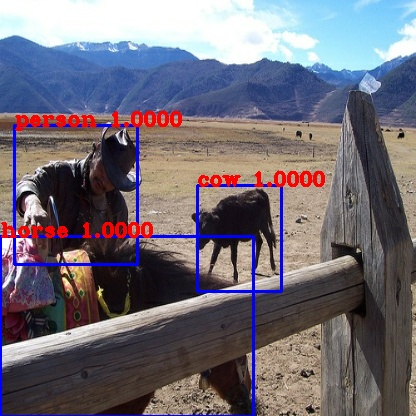

In [18]:
#Run this cell 5 or more times and save the output images.
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

from IPython.display import Image
Image(filename='./output.jpg')

# Task 2: Comment on your observations on object detection for the 5 sample Pascal VOC images from above.

### 10. Next retrain the model using the PASCAL VOC train/validation images below.
## (Caution) This will take sometime!

In [19]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2021-09-20 03:37:37.482777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:37.491986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:37.492782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:37.509032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 03:37:37.509853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

# Task 3: Lets analyze the training process and figure out what is the role of specific functions.
## Step 1: Under GDrive folder YOLOv3->yolov3-tf2 analyze the functions in 'train.py'. Write down the steps that the function is performing [Similar to pseudo-code writing]. Feel free to discuss this over slack.

## Step 2: Under GDrive folder YOLOv3->yolov3-tf2->yolov3-tf2 analyze the functions in 'models.py'. Can you match these functions with the model steps mentioned in Steps 4 and 5 above?

### 11. Apply the fine tuned weights on the images from test_images folder.
# Task 4: Collect your outputs on the images from test_images folder.
This can be achieved by modifying FLAGS.image.

I0920 01:51:45.709420 139980539103104 <ipython-input-18-66ad2673b1e3>:16] weights loaded
I0920 01:51:45.717065 139980539103104 <ipython-input-18-66ad2673b1e3>:19] classes loaded
I0920 01:51:45.911060 139980539103104 <ipython-input-18-66ad2673b1e3>:30] time: 0.1448674201965332
I0920 01:51:45.914047 139980539103104 <ipython-input-18-66ad2673b1e3>:32] detections:
I0920 01:51:45.923129 139980539103104 <ipython-input-18-66ad2673b1e3>:36] 	person, 0.49667078256607056, [0.65038115 0.42763656 0.7761324  0.8348095 ]
I0920 01:51:45.931437 139980539103104 <ipython-input-18-66ad2673b1e3>:36] 	person, 0.2789026200771332, [0.6558893  0.38634354 0.76546836 0.80433136]
I0920 01:51:45.939782 139980539103104 <ipython-input-18-66ad2673b1e3>:36] 	person, 0.24985450506210327, [0.5965488  0.31805992 0.6832305  0.79171216]


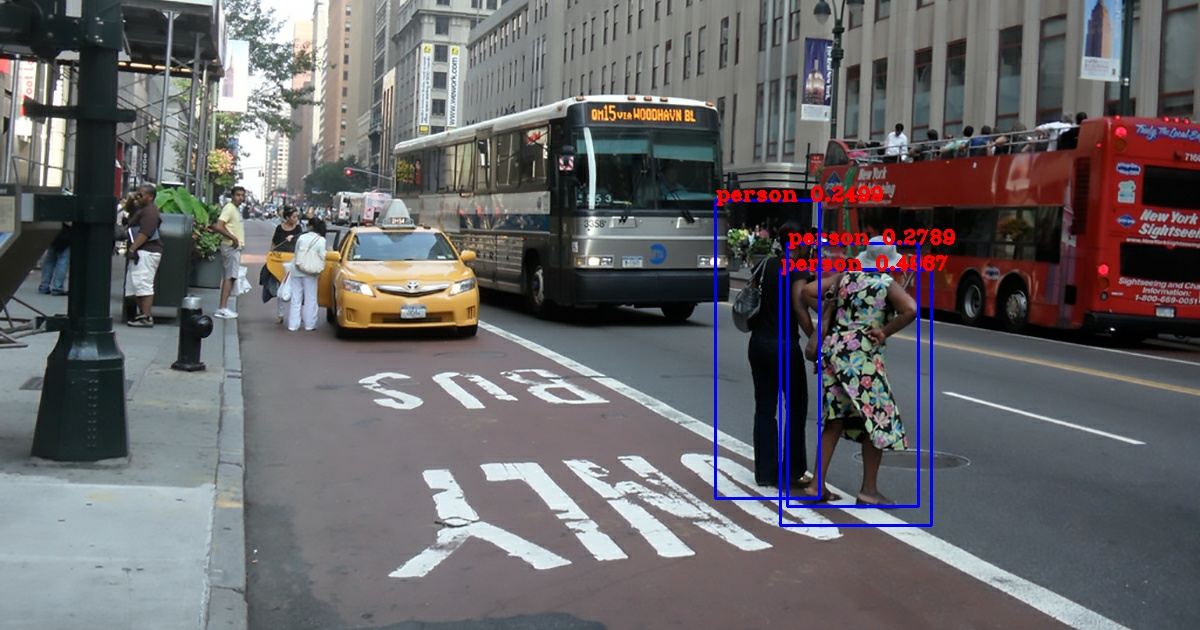

In [ ]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/street.jpg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

# We notice that since fine tuning had lesser class categories, we now observe fewer bounding boxes. This is the fine-tuning process.

# Final Submission for this assignment includes a folder with following structure
``` Results
      |_______No training
                  |____004.jpg
                  |_____giraffe.jpg
                  |_____test.jpg
      |_______Training
                  |____004.jpg
                  |_____giraffe.jpg
                  |_____test.jpg
                  
```

# Here folder 'No training' contains images with the bounding boxes before fine tuning and 'Training' contains images with the bounding boxes after fine tuning.